# Unit cost-benefit

### Imports

In [1]:
import pandas as pd
import plotnine as p9

## Data cleaning

In [2]:
data = {}

## Tier base-stats
for i in range(5): # 5 tiers
    data[f"tier_{i + 1}"] = pd.read_excel("data/2021-12-29_DespotsGame_UnitStats.xlsx", sheet_name=i).dropna(axis="columns", how="all").fillna(0)

## Bonus stats per level
data["bonus"] = pd.read_excel("data/2021-12-29_DespotsGame_UnitStats.xlsx", sheet_name=i + 1).dropna(axis="columns").fillna(0)

In [3]:
data["tier_3"]

,Level_3,Tank,Fencer,Trickster,Figther,Healer,Thrower,Shooter,Cultist,Mage,Egghead
0,attack_dmg,58.0,100.0,180.0,80.0,10.0,140.0,75.0,120.0,180.0,74.0
1,attack_spd,0.0,0.0,40.0,30.0,0.0,40.0,0.0,20.0,0.0,0.0
2,armor,35.0,10.0,16.0,20.0,7.0,0.0,0.0,13.0,12.0,12.0
3,health,430.0,310.0,230.0,390.0,90.0,150.0,70.0,210.0,60.0,210.0
4,mana,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0
5,movement,0.0,20.0,20.0,30.0,20.0,20.0,20.0,20.0,20.0,-10.0
6,range,0.0,0.0,1.5,0.0,3.0,4.0,10.0,5.0,12.0,6.0
7,cost,15.0,12.0,17.0,13.0,11.0,19.0,15.0,18.0,17.0,17.0


In [4]:
data["bonus"]

,Tier,Class,Variable,Bonus_pct
0,1,Tank,attack_dmg,3
1,1,Tank,health,3
2,2,Tank,attack_dmg,4
3,2,Tank,health,5
4,3,Tank,attack_dmg,3
...,...,...,...,...
75,3,Egghead,health,10
76,4,Egghead,attack_dmg,4
77,4,Egghead,health,10
78,5,Egghead,attack_dmg,5


In [5]:

def tidy_melt(data : dict, tier : int):    

    dframe = data[f"tier_{tier}"]
    level_name = f"Level_{tier}"

    dframe_melt = pd.melt(dframe, id_vars = [f"Level_{tier}"], var_name="Class").rename(columns = {level_name : "Variable"}).assign(Tier = tier)
    dframe_melt= pd.merge(dframe_melt, data["bonus"], on= [ "Tier", "Class", "Variable" ], how="left" ).fillna(0)

    return dframe_melt

In [6]:
dframe_stats = pd.concat( [ tidy_melt(data, tier=i) for i in range(1,6) ] )
dframe_stats.sample(10)

,Variable,Class,value,Tier,Bonus_pct
59,health,Cultist,140.0,2,0.0
40,attack_dmg,Thrower,140.0,2,0.0
74,armor,Egghead,11.0,2,0.0
11,health,Fencer,110.0,1,5.0
35,health,Healer,90.0,3,10.0
37,movement,Healer,20.0,4,0.0
41,attack_spd,Thrower,0.0,1,0.0
68,mana,Mage,0.0,2,0.0
43,health,Thrower,100.0,4,0.0
23,cost,Trickster,29.0,5,0.0


## Visualization

## Growth per class tier

In this plot we can see which unit statistic increases over tiers.

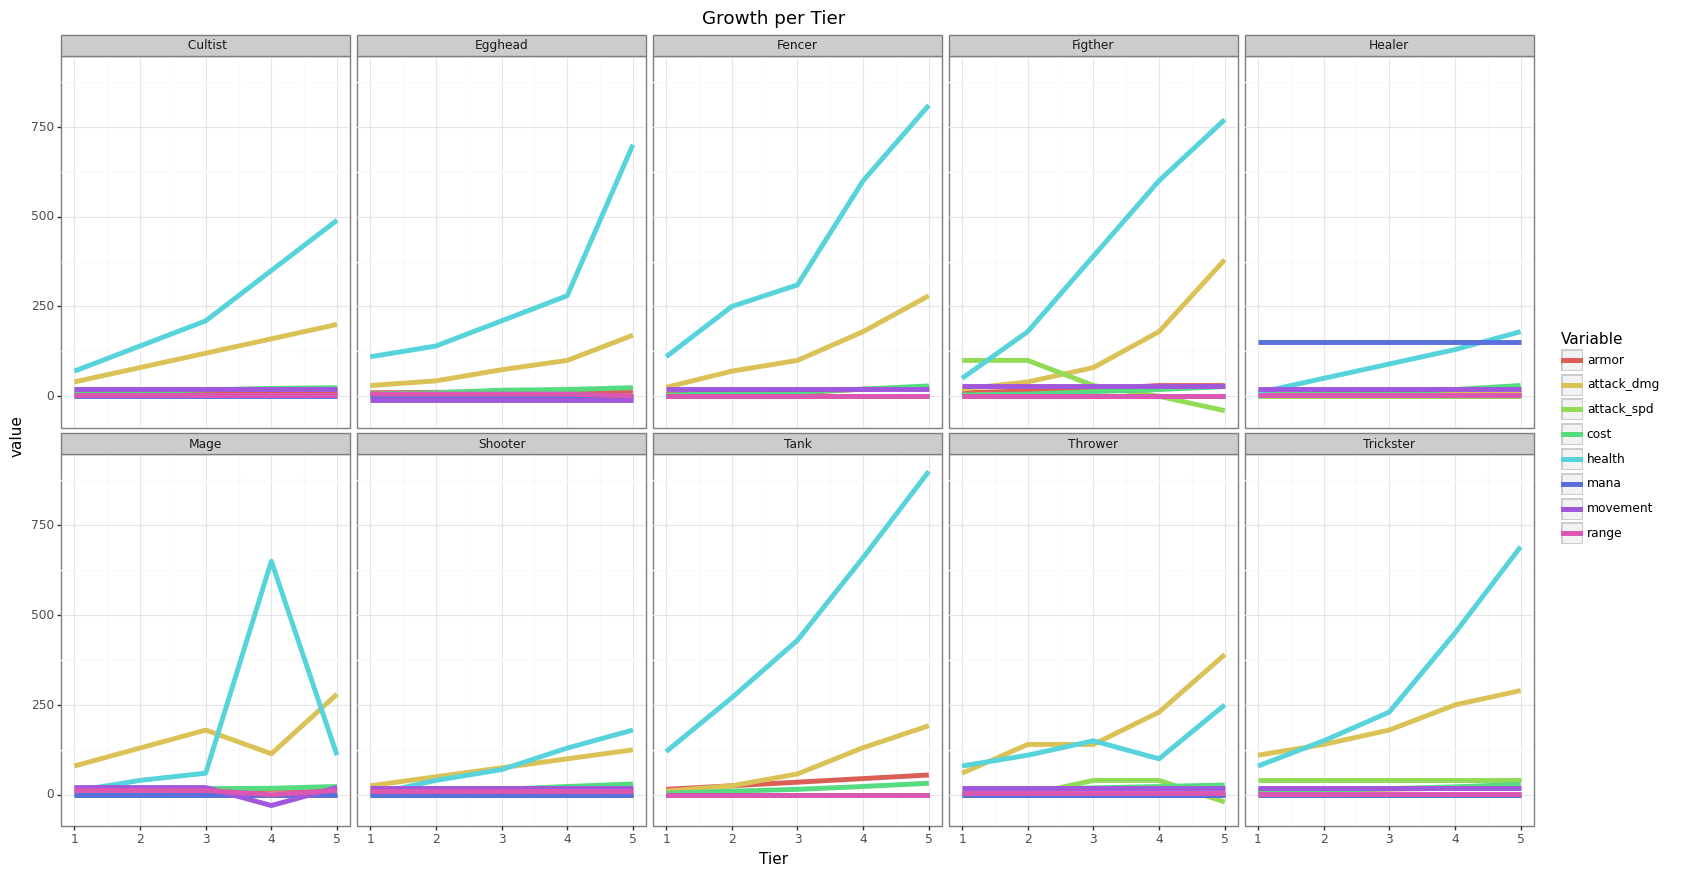

<ggplot: (8730782089710)>

In [7]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_stats) + 
 p9.aes(x = "Tier", y = "value", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", nrow=2) +
 p9.theme_bw() +
 p9.ggtitle("Growth per Tier")
)

display(gg_unit_trend)

#### On a log-scale

Because some stats are negative, the scale of stats was slided down so that the minimum value is 0.01, otherwise the trendlines wouldn't be able to render.

/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


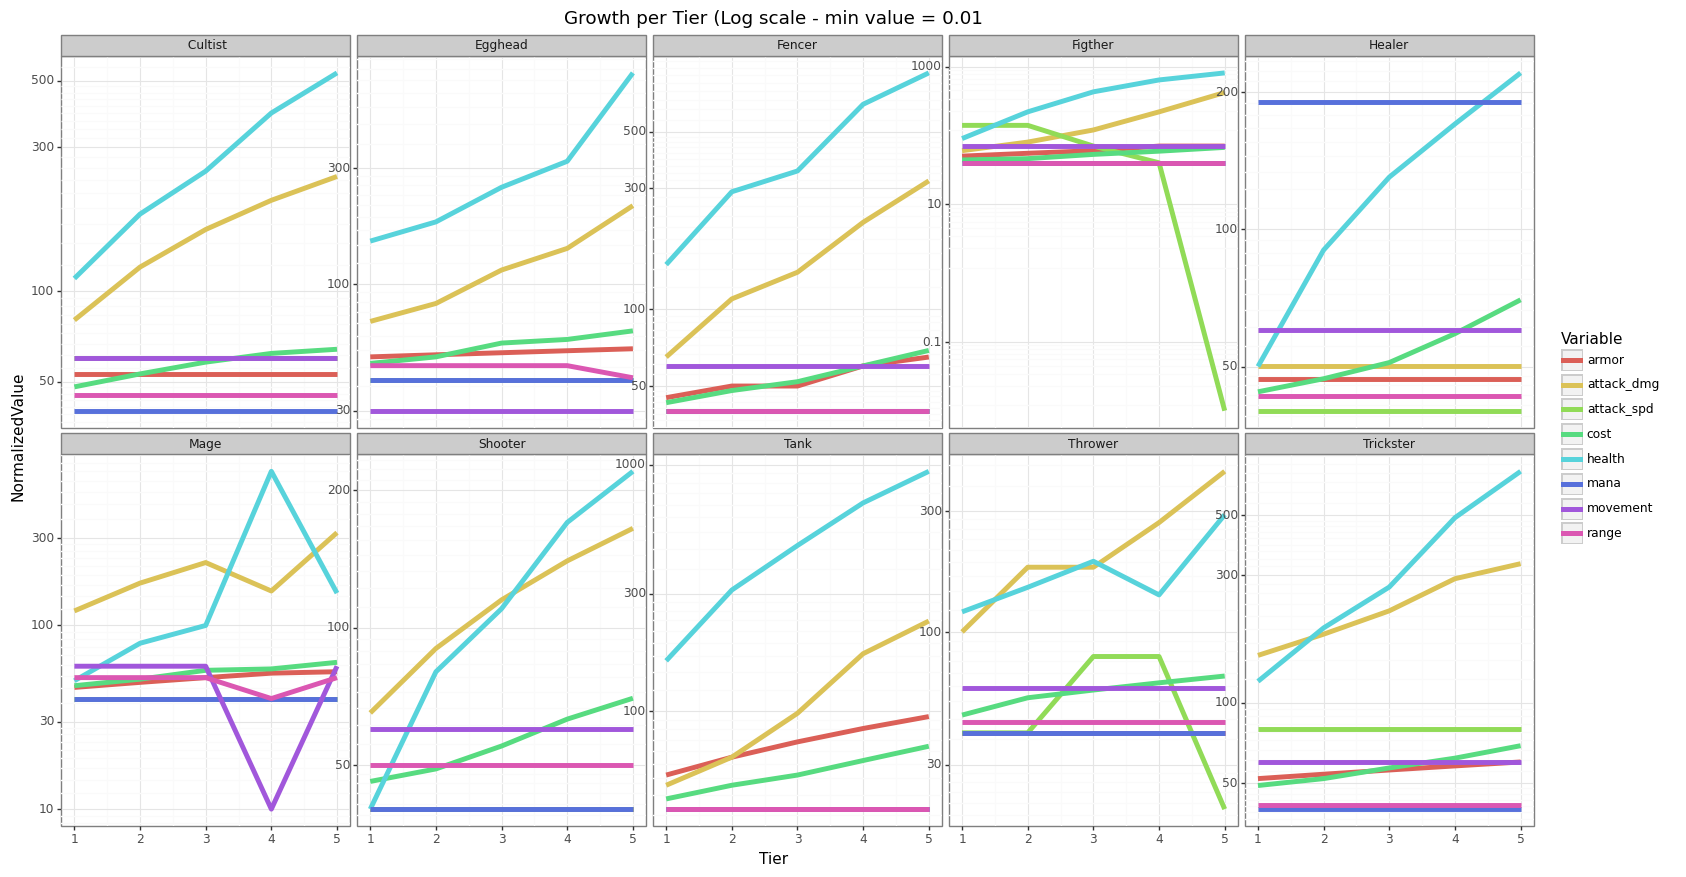

<ggplot: (8730771377752)>

In [8]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_stats.assign(NormalizedValue = dframe_stats["value"] - dframe_stats["value"].min() + 0.01 )) + 
 p9.aes(x = "Tier", y = "NormalizedValue", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", nrow=2, scales="free_y") +
 p9.theme_bw() +
 p9.ggtitle("Growth per Tier (Log scale - min value = 0.01")
)

display( gg_unit_trend + p9.scale_y_log10() )

### Growth within stats

For this visualization we're focusing on the individual statistics for comparison between classes.

/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


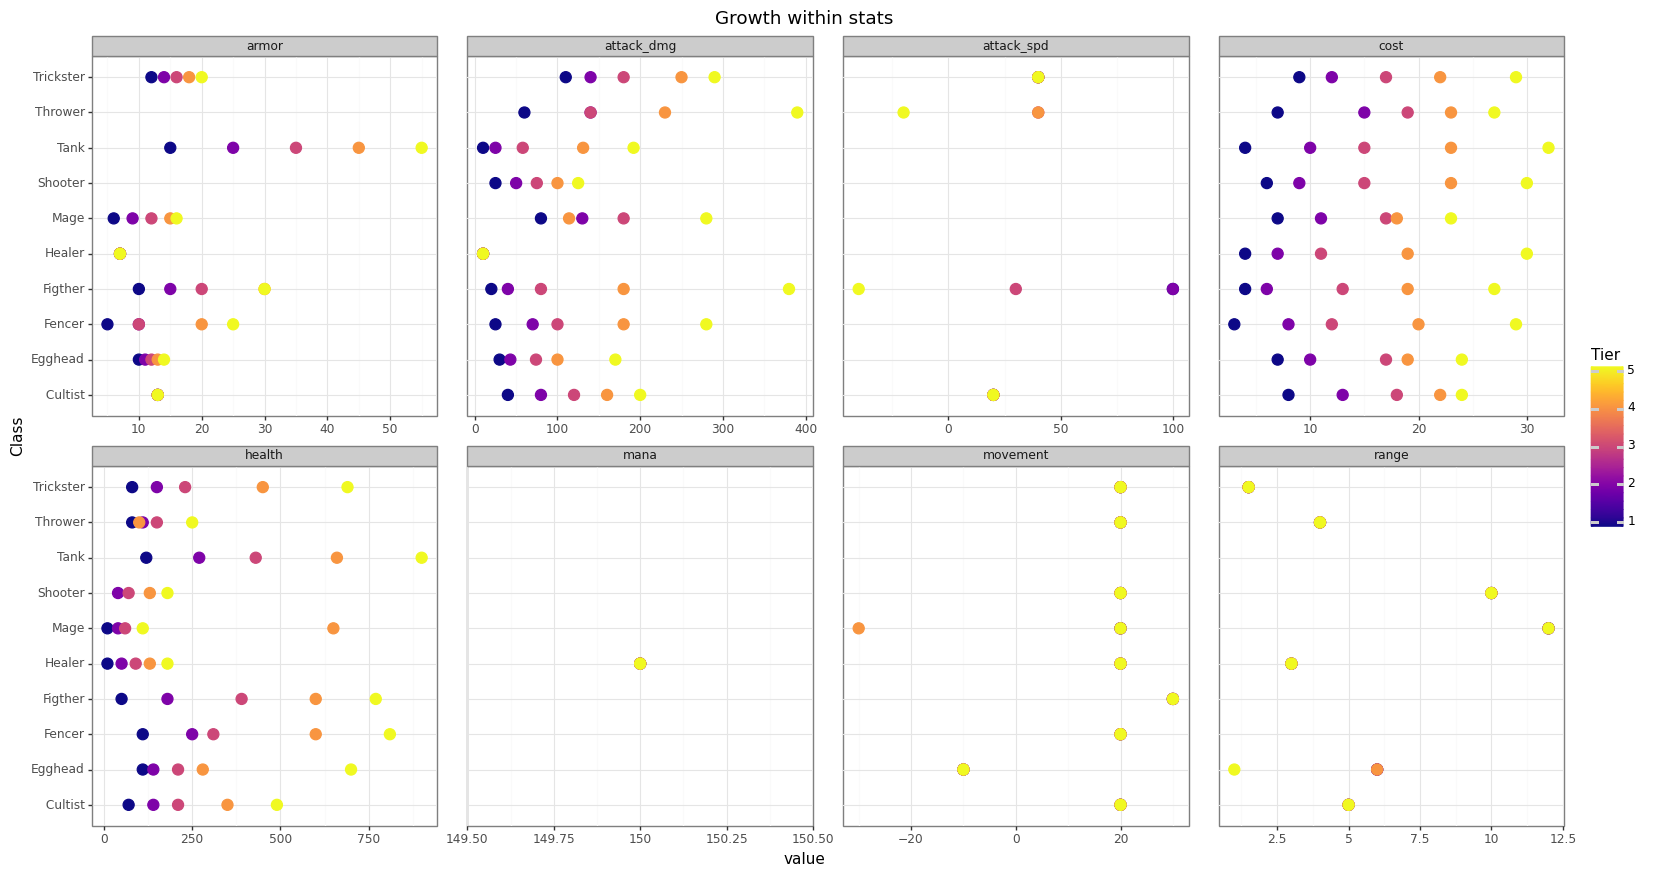

<ggplot: (8730770965547)>

In [9]:
p9.options.figure_size = 19,10

(p9.ggplot(dframe_stats.query("value != 0") ) + 
 p9.aes(x = "value", y = "Class", color = "Tier") +
 p9.geom_point(size=4) +
 p9.facet_wrap("Variable", nrow=2, scales="free_x") + 
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.3) +
 p9.ggtitle("Growth within stats") +
 p9.scale_color_continuous("plasma") 
)